## Objective
Make RT-Sort spike assignment very fast

## Setup

In [1]:
%load_ext autoreload

In [2]:
from time import perf_counter

import numpy as np
import matplotlib.pyplot as plt

%autoreload 2
from src import utils

In [3]:
def sigmoid(x):
    exp = np.exp(x)
    return exp / (1 + exp)

In [4]:
TRACES = np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/traces.npy", mmap_mode="r")
OUTPUTS = np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/outputs.npy", mmap_mode="r")
ALL_SEQUENCES = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/230113/merged_sequences.pickle")

In [5]:
SAMP_FREQ = 32  # kHz
FRONT_BUFFER = 60
N_BEFORE = N_AFTER = round(0.5 * SAMP_FREQ)

In [6]:
TEST_TIME = 22681.78125

In [7]:
start_time = perf_counter()
output_frame = round(TEST_TIME * SAMP_FREQ) - FRONT_BUFFER
end_time = perf_counter()
print((end_time - start_time)*1000)

0.10591201134957373


In [8]:
elec_to_seqs = {}
for seq in ALL_SEQUENCES:
    if seq.root_elec not in elec_to_seqs:
        elec_to_seqs[seq.root_elec] = [seq]
    else:
        elec_to_seqs[seq.root_elec].append(seq)

In [9]:
seq = ALL_SEQUENCES[4]

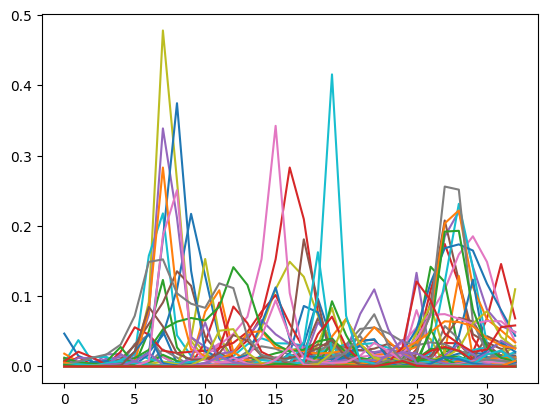

In [10]:
output_window = OUTPUTS[:, output_frame-N_BEFORE:output_frame+N_AFTER+1]
plt.plot(sigmoid(output_window.T))
plt.show()

In [11]:
def sigmoid_inverse(y):
    return -np.log(1 / y - 1)

root_elec = 3
strict_thresh_logit = sigmoid_inverse(0.1)# -1.7346010553881064
LOOSE_THRESH_LOGIT = -2.1972245773362196

MIN_LOOSE_DETECTIONS_N = 3 
MIN_LOOSE_DETECTIONS_R = 2/3
MIN_INNER_LOOSE_DETECTIONS = 2

CLIP_LATENCY_DIFF = 5
CLIP_AMP_DIFF = 1

MAX_LATENCY_DIFF_SPIKES = 2.5
MAX_AMP_MEDIAN_DIFF_SPIKES = 0.35
MAX_ROOT_AMP_MEDIAN_STD = 2

In [12]:
import torch

for seq in ALL_SEQUENCES:
    seq.nor_comp_elecs = seq.comp_elecs[1:]
    
    # elec_rel_comp_elec = {comp_elec: i for i, comp_elec in enumerate(seq.comp_elecs)}  # After slicing with comp_elecs, loose and inner loose elecs need to be relative to comp_elec
    # seq.test_inner_loose_elecs = torch.tensor([elec_rel_comp_elec[elec] for elec in seq.inner_loose_elecs], dtype=torch.int32, device="cuda")
    # seq.test_loose_elecs = torch.tensor([elec_rel_comp_elec[elec] for elec in seq.loose_elecs], dtype=torch.int32, device="cuda")
    seq.test_inner_loose_elecs = torch.tensor([1 if elec in seq.inner_loose_elecs else 0 for elec in seq.comp_elecs], dtype=torch.bool, device="cuda")  # Binary array (1 for comp_elec in inner_loose_elecs, else 0)
    seq.test_loose_elecs = torch.tensor([1 if elec in seq.loose_elecs else 0 for elec in seq.comp_elecs], dtype=torch.bool, device="cuda")  # Binary array (1 for comp_elec in loose_elecs, else 0)
    
    seq.test_latencies = torch.tensor(seq.all_latencies[seq.nor_comp_elecs], dtype=torch.float16, device="cuda")
    seq.test_amps = torch.tensor(seq.all_amp_medians[seq.comp_elecs], dtype=torch.float16, device="cuda")
    
    elec_probs = seq.all_elec_probs[seq.comp_elecs]
    seq.test_latency_weights = torch.tensor(elec_probs[1:]/np.sum(elec_probs[1:]), dtype=torch.float16, device="cuda")
    seq.test_amp_weights = torch.tensor(elec_probs/np.sum(elec_probs), dtype=torch.float16, device="cuda")

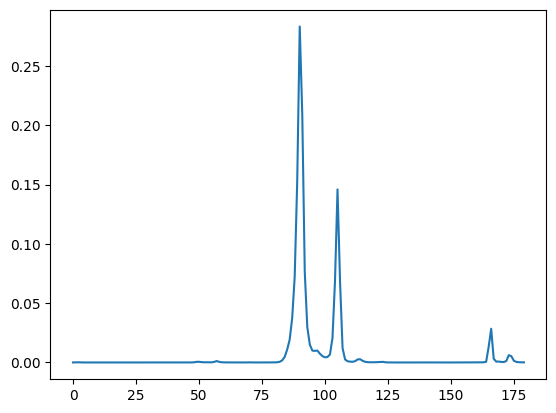

In [13]:
output_window = OUTPUTS[:, output_frame-90:output_frame+90]
plt.plot(sigmoid(output_window[3].T))
plt.show()

In [275]:
from math import ceil

seq = ALL_SEQUENCES[4]
latencies = seq.all_latencies[seq.comp_elecs]
seq_n_before = ceil(np.abs(np.min(latencies))) + CLIP_LATENCY_DIFF
seq_n_after = ceil(np.max(latencies)) + CLIP_LATENCY_DIFF
print(seq_n_before, seq_n_after)

14 11


In [276]:
seq.root_to_amp_median_std

{3: 1.337}

In [277]:
strict_thresh_logit = sigmoid_inverse(0.1)

In [295]:
torch.cuda.empty_cache()
NUM_SEQS = 60
detections = [[] for _ in range(NUM_SEQS)]

seq = ALL_SEQUENCES[4]
latencies = seq.all_latencies[seq.comp_elecs]
seq_n_before = 16# ceil(np.abs(np.min(latencies))) + CLIP_LATENCY_DIFF
seq_n_after = 11#ceil(np.max(latencies)) + CLIP_LATENCY_DIFF 

comp_elecs_np = seq.comp_elecs
comp_elecs = torch.tensor(seq.comp_elecs, device="cuda")[:, None]
comp_elecs_flattened = comp_elecs.flatten()

nor_comp_elecs = seq.nor_comp_elecs

max_pool = torch.nn.MaxPool1d(seq_n_before+seq_n_after+1, return_indices=True)

torch_window = torch.tensor(output_window, device="cuda")

samp_elecs = [0, 1, 2, 3, 4]

seqs_root_elecs = [seq.root_elec for _ in range(NUM_SEQS)] # [seq.root_elec for i in range(NUM_SEQS)]
seqs_root_elecs_rel_comp_elecs = [list(comp_elecs).index(root_elec) for root_elec in seqs_root_elecs]
seqs_template_inner_loose_elecs = torch.vstack([seq.test_inner_loose_elecs for i in range(NUM_SEQS)])
seqs_min_inner_loose_elecs = torch.tensor([seq.min_loose_detections for i in range(NUM_SEQS)], dtype=torch.float16, device="cuda")
seqs_template_loose_elecs = torch.vstack([seq.test_loose_elecs for i in range(NUM_SEQS)])

seqs_template_latencies = torch.vstack([seq.test_latencies for i in range(NUM_SEQS)]) + seq_n_before  # +seq_n_before so offset relative to window
seqs_latency_weights = torch.vstack([seq.test_latency_weights for i in range(NUM_SEQS)])

seqs_template_amps = torch.vstack([seq.test_amps for i in range(NUM_SEQS)])
seqs_root_amp_mean = torch.tensor([seq.all_amp_medians[seq.root_elec] for i in range(NUM_SEQS)], dtype=torch.float16, device="cuda")
seqs_root_amp_std = torch.tensor([seq.root_to_amp_median_std[seq.root_elec] for i in range(NUM_SEQS)], dtype=torch.float16, device="cuda")
seqs_amp_weights = torch.vstack([seq.test_amp_weights for i in range(NUM_SEQS)])

# for thing in (seqs_template_latencies, seqs_latency_weights, seqs_template_amps, seqs_amp_weights):
#     thing *= torch.randn_like(thing)

pre_frames = round(50 * SAMP_FREQ)
rec_frame = round(TEST_TIME * SAMP_FREQ)
pre_medians = TRACES[:, rec_frame-pre_frames:rec_frame]
pre_medians = np.median(np.abs(pre_medians), axis=1)
pre_medians = np.clip(pre_medians / 0.6745, a_min=0.5, a_max=None) 
pre_medians = torch.tensor(pre_medians, dtype=torch.float16, device="cuda")

rec_window = torch.tensor(TRACES[:, rec_frame-90:rec_frame+90], dtype=torch.float16, device="cuda")
rec_window_size = 90+90
spike_arange = torch.arange(0, seq_n_before+seq_n_after+1, device="cuda")# torch.arange(-seq_n_before, seq_n_after+1, device="cuda")

start_time = perf_counter()

pre_medians = TRACES[comp_elecs_np, rec_frame-pre_frames:rec_frame]
pre_medians = np.median(np.abs(pre_medians), axis=1)
pre_medians = np.clip(pre_medians / 0.6745, a_min=0.5, a_max=None) 
pre_medians = torch.tensor(pre_medians, dtype=torch.float16, device="cuda")
# pre_medians_comp = pre_medians[comp_elecs_flattened]

window = torch_window[samp_elecs, seq_n_before-1:-seq_n_after+1] # -1 and +1 to identify peaks
main = window[:, 1:-1]
greater_than_left = main > window[:, :-2]
greater_than_right = main > window[:, 2:]
# window = torch_window[:NUM_ELECS] # -1 and +1 to identify peaks
# main = window[:, seq_n_before:-seq_n_after]
# greater_than_left = main > window[:, seq_n_before-1:-seq_n_after-1]
# greater_than_right = main > window[:, seq_n_before+1:-seq_n_after+1]
peaks = greater_than_left & greater_than_right
crosses = main >= sigmoid_inverse(0.1)
peak_ind_flat = torch.nonzero(peaks & crosses, as_tuple=True)[1] # now done in spike_arange: + seq_n_before
peak_ind = peak_ind_flat[:, None, None]  # Relative to seq_n_before in output_window

# spike_window = torch.stack([torch_window[comp_elecs, idx-seq_n_before:idx+seq_n_after+1] for idx in peak_ind if seq_n_before <= idx+1 < rec_window_size-seq_n_after])
spike_window = torch_window[comp_elecs, peak_ind + spike_arange]

elec_probs, latencies = max_pool(spike_window)  # Latencies are relative to peak-seq_n_before

elec_crosses = (elec_probs >= LOOSE_THRESH_LOGIT).transpose(1, 2)
num_inner_loose = torch.sum(elec_crosses & seqs_template_inner_loose_elecs, dim=2)
pass_inner_loose = num_inner_loose >= MIN_INNER_LOOSE_DETECTIONS

num_loose = torch.sum(elec_crosses & seqs_template_loose_elecs, dim=2)
pass_loose = num_loose >= seqs_min_inner_loose_elecs

latencies_float = latencies[:, 1:, :].transpose(1, 2).to(torch.float16)
latency_diff = torch.abs(latencies_float - seqs_template_latencies)
latency_diff = torch.clip(latency_diff, min=None, max=CLIP_LATENCY_DIFF)
latency_diff = torch.sum(latency_diff * seqs_latency_weights, axis=2)
pass_latency = latency_diff <= MAX_LATENCY_DIFF_SPIKES

amps = torch.abs(rec_window[comp_elecs, peak_ind + latencies].transpose(1, 2)) / pre_medians_comp  # peak_ind+seq_n_before = peak_ind_in_rec_window. latency-seq_n_before = latency_rel_peak_ind. --> (peak_ind+seq_n_before)+(latency-seq_n_before) = peak_ind+latency = spike index in rec_window

root_amp_z = torch.abs(amps[:, 0, seqs_root_elecs_rel_comp_elecs] - seqs_root_amp_mean) / seqs_root_amp_std
pass_root_amp_z = root_amp_z <= MAX_ROOT_AMP_MEDIAN_STD

amp_diff = torch.abs(amps - seqs_template_amps) / seqs_template_amps
amp_diff = torch.clip(amp_diff, min=None, max=CLIP_AMP_DIFF)
amp_diff = torch.sum(amp_diff * seqs_amp_weights, axis=2)
pass_amp_diff = amp_diff <= MAX_AMP_MEDIAN_DIFF_SPIKES

can_spike = pass_inner_loose & pass_loose & pass_latency & pass_root_amp_z & pass_amp_diff

# Slighty faster than the following due to only slicing once: # spike_scores = latency_diff[can_spike] / MAX_LATENCY_DIFF_SPIKES + amp_diff[can_spike] / MAX_AMP_MEDIAN_DIFF_SPIKES  - num_loose[can_spike] / torch.sum(elec_crosses, dim=2)
spike_scores = latency_diff / MAX_LATENCY_DIFF_SPIKES + amp_diff / MAX_AMP_MEDIAN_DIFF_SPIKES - num_loose / torch.sum(elec_crosses, dim=2)
spike_scores = 2 - spike_scores
# spike_scores = spike_scores[can_spike]
# spike_scores = torch.topk(spike_scores, 2)

can_spike[-1, -1] = True # TODO: Remove this

spike_scores *= can_spike

peak_ind_2d = peak_ind[:, 0]
while torch.any(spike_scores):
    spike_seq_idx = torch.argmax(spike_scores).item()
    spike_idx = spike_seq_idx // NUM_SEQS
    seq_idx = spike_seq_idx % NUM_SEQS
    spike_time = peak_ind_flat[spike_idx]
    # region Only one spike within OVERLAP
    spike_scores *= seq_no_overlap_mask[seq_idx] & (torch.abs(peak_ind_2d - spike_time) > OVERLAP)
    detections[seq_idx].append(spike_time + seq_n_before)
    # endregion
    
    # region Allow multiple spikes within OVERLAP. TODO: Don't just sample from first 15 elecs, need to do outer elecs
    # spike_time = peak_ind[spike_idx] + seq_n_before
    # above_thresh = torch_window[:15, spike_time-N_BEFORE:spike_time+N_AFTER+1] >= LOOSE_THRESH_LOGIT
    # peaks = ~above_thresh[:, :-1] & above_thresh[:, 1:]
    # num_spikes = torch.sum(peaks, dim=1)
    # num_spikes = torch.max(num_spikes)
    # spike_seq_ind = torch.topk(spike_scores.flatten(), num_spikes, sorted=False).indices
    # for spike_seq_idx in spike_seq_ind:
    #     spike_seq_idx = spike_seq_idx.item()
    #     spike_idx = spike_seq_idx // NUM_SEQS
    #     seq_idx = spike_seq_idx % NUM_SEQS
    #     spike_time = peak_ind_flat[spike_idx]
    #     spike_scores *= seq_no_overlap_mask[seq_idx] & (torch.abs(peak_ind_2d - spike_time) > OVERLAP)
    #     detections[seq_idx].append(spike_time + seq_n_before)
    # endregion

# region Development
# spike_scores = torch.sort(spike_scores)[0]
# last_i = 0
# for i, diff in enumerate(torch.diff(spike_times)):
#     if diff >= 4:
#         time = torch.div(spike_times[i] + spike_times[last_i], 2, rounding_mode="floor")
#         assert False, "Can be done in parrallel"
#         above_thresh = torch_window[:15, time-N_BEFORE:time+N_AFTER+1] >= LOOSE_THRESH_LOGIT
#         peaks = ~above_thresh[:, :-1] & above_thresh[:, 1:]
#         num_spikes = torch.sum(peaks, dim=1)
#         num_spikes = torch.max(num_spikes)
#         detections.extend(torch.topk(spike_scores[last_i:i+1], num_spikes))
#         last_i = i+1
# time = torch.div(spike_times[i] + spike_times[last_i], 2, rounding_mode="floor")
# above_thresh = torch_window[:15, time-N_BEFORE:time+N_AFTER+1] >= LOOSE_THRESH_LOGIT
# peaks = ~above_thresh[:, :-1] & above_thresh[:, 1:]
# num_spikes = torch.sum(peaks, dim=1)
# num_spikes = torch.max(num_spikes)
# detections.extend(torch.topk(spike_scores[last_i:i+1], num_spikes))

# amps = torch.abs()
# Each root elec separately
# for elec in range(10):
#     window = torch_window[elec]
#     main = window[1:-1]
#     greater_than_left = main > window[:-2]
#     greater_than_right = main > window[2:]
#     peaks = greater_than_left & greater_than_right
#     crosses = main >= strict_thresh_logit
#     peak_ind = torch.nonzero(peaks & crosses) + 1
#     if len(peak_ind) == 0:
#         continue
    
#     pre_medians_comp = pre_medians[comp_elecs]
    
#     spike_window = torch.stack([torch_window[comp_elecs.flatten(), idx-seq_n_before:idx+seq_n_after+1] for idx in peak_ind])
#     # spike_window = torch.stack([torch_window[comp_elecs, idx-seq_n_before:idx+seq_n_after+1] for idx in peak_ind])
#     elec_probs, latencies = max_pool(spike_window)
#     latencies_float = torch.transpose(latencies[:, 1:, :], 1, 2).to(torch.float16) - seq_n_before
#     latency_diff = torch.abs(latencies_float - seqs_template_latencies)
#     latency_diff = torch.clip(latency_diff, max=CLIP_LATENCY_DIFF)
#     latency_diff = torch.sum(latency_diff * seqs_latency_weights, axis=2)
#     print(latency_diff)
        
    # Each peak separately
    # for idx in peak_ind:
    #     spike_window = torch_window[comp_elecs, idx-seq_n_before:idx+seq_n_after+1]
    #     elec_probs, latencies = max_pool(spike_window)
    #     latencies = latencies.flatten()
        
    #     latencies_float = latencies[1:].to(torch.float16) - seq_n_before
    #     latency_diff = torch.abs(latencies_float - seqs_template_latencies)
    #     latency_diff = torch.clip(latency_diff, max=CLIP_LATENCY_DIFF)
    #     latency_diff = torch.sum(latency_diff * seqs_latency_weights, axis=1)

    #     amps = torch.abs(rec_window[comp_elecs, idx-seq_n_before+latencies]) / pre_medians_comp
    #     amp_diff = torch.abs(amps - seqs_template_amps) / seqs_template_amps
    #     amp_diff = torch.clip(amp_diff, max=CLIP_AMP_DIFF)
    #     amp_diff = torch.sum(amp_diff * seqs_amp_weights, axis=1)
       
#         #     if torch.sum(elec_probs[seq.inner_loose_elecs] >= loose_thresh_logit) < MIN_INNER_LOOSE_DETECTIONS:
#         #         continue
            
#         #     if torch.sum(elec_probs[seq.loose_elecs] >= loose_thresh_logit) < MIN_LOOSE_DETECTIONS_N:
#         #         continue
# endregion
        
torch.cuda.synchronize()
end_time = perf_counter()
print((end_time-start_time)*1000)
# print(latency_diff)
print(amp_diff)

# sigmoided = sigmoid6(output_window)
# plt.plot(sigmoided)
# plt.scatter(peaks, sigmoided[peaks], color="orange")
# plt.show()

3.9340590010397136
tensor([[0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602,
         0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602,
         0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602,
         0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602,
         0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602,
         0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602,
         0.1602, 0.1602, 0.1602, 0.1602, 0.1602, 0.1602],
        [0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155,
         0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155,
         0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155,
         0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155,
         0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155, 0.2155,
         0.2155, 0.2155, 0.2155,

In [284]:
spike_window.shape

torch.Size([3, 13, 26])

In [28]:
(spike_scores * can_spike).flatten()

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.7051, 1.7051, 1.7051,
        1.7051, 1.7051, 1.7051, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')

In [260]:
comp_elecs

tensor([[  3],
        [ 97],
        [  2],
        [ 99],
        [ 98],
        [195],
        [194],
        [  1],
        [  4],
        [290],
        [196],
        [291],
        [100]], device='cuda:0')

In [262]:
can_spike[-1, -1] = True
OVERLAP = 6
peak_ind_2d = peak_ind[:, 0]
while torch.any(can_spike):
    spike_seq_idx = torch.argmax((spike_scores * can_spike)).item()
    spike_idx = spike_seq_idx // NUM_SEQS
    seq_idx = spike_seq_idx % NUM_SEQS

    print(spike_idx, seq_idx)

    can_spike &= seq_no_overlap_mask[seq_idx] & (torch.abs(peak_ind_2d - peak_ind_flat[spike_idx]) > OVERLAP)

    if not torch.any(can_spike):
        break

1 0
2 5


In [ ]:
torch.abs(peak_ind_2d - peak_ind_flat[spike_idx]) > OVERLAP

In [250]:
torch.abs(peak_ind[:, 0] - peak_ind_flat[spike_idx]) > OVERLAP

tensor([[ True],
        [False],
        [ True]], device='cuda:0')

In [109]:
((2-spike_scores) * can_spike).flatten()

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.7051, 1.7051, 1.7051,
        1.7051, 1.7051, 1.7051, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5664],
       device='cuda:0')

In [108]:
torch.argmax(((2-spike_scores) * can_spike).flatten())

tensor(6, device='cuda:0')

In [32]:
can_spike[2, -1] = True
can_spike

tensor([[False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True]], device='cuda:0')

In [49]:
torch.abs((can_spike * peak_ind[:, 0]) - 76) >= 6

tensor([[ True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True]], device='cuda:0')

In [37]:
can_spike

tensor([[False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True]], device='cuda:0')

In [33]:
spike_scores[can_spike]

tensor([0.2949, 0.2949, 0.2949, 0.2949, 0.2949, 0.2949, 1.4336],
       device='cuda:0')

In [44]:
can_spike * spike_scores

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2949, 0.2949, 0.2949, 0.2949, 0.2949, 0.2949],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.4336]], device='cuda:0')

In [43]:
spike_scores

tensor([[1.4570, 1.4570, 1.4570, 1.4570, 1.4570, 1.4570],
        [0.2949, 0.2949, 0.2949, 0.2949, 0.2949, 0.2949],
        [1.4336, 1.4336, 1.4336, 1.4336, 1.4336, 1.4336]], device='cuda:0')

In [41]:
can_spike.flatten()

tensor([False, False, False, False, False, False,  True,  True,  True,  True,
         True,  True, False, False, False, False, False,  True],
       device='cuda:0')

In [178]:
OVERLAP = 6
seq_no_overlap_mask = torch.tensor([[0 for _ in range(NUM_SEQS)] for _ in range(NUM_SEQS)], dtype=torch.bool, device="cuda")

In [179]:
seq_no_overlap_mask.shape

torch.Size([60, 60])

In [994]:
spike_times = torch.tensor([95, 95, 96, 105, 107, 120])
spike_scores = torch.tensor([0, 1, 0, 1, 0, 0])
last_i = 0
for i, diff in enumerate(torch.diff(spike_times)):
    if diff >= 4:
        time = torch.div(spike_times[i] + spike_times[last_i], 2, rounding_mode="floor")
        above_thresh = torch_window[:15, time-N_BEFORE:time+N_AFTER+1] >= LOOSE_THRESH_LOGIT
        peaks = ~above_thresh[:, :-1] & above_thresh[:, 1:]
        num_spikes = torch.sum(peaks, dim=1)
        num_spikes = torch.max(num_spikes)
        detections.extend(torch.topk(spike_scores[last_i:i], num_spikes))
        last_i = i+1
        
        

In [993]:
np.diff(spike_times)

array([ 0,  1,  9,  2, 13])

In [673]:
print(num_loose / torch.sum(elec_crosses, dim=2))
print(torch.sum(elec_crosses, dim=2).shape)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]], device='cuda:0')
torch.Size([3, 1])


In [674]:
num_loose

tensor([[4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4],
        [2, 2, 2, 2, 2, 2]], device='cuda:0')

In [676]:
torch.sum(elec_crosses, dim=2)

tensor([[4],
        [4],
        [2]], device='cuda:0')

In [1]:
test = torch.tensor([1, 2], dtype=torch.float16, device="cuda")
start = perf_counter()

new = test - 0

end = perf_counter()
(end - start)*1000

NameError: name 'perf_counter' is not defined

In [891]:
num_spikes

tensor(2, device='cuda:0')

In [853]:
num_spikes

tensor(3, device='cuda:0')

In [769]:
torch.tensor([  # (chans, samples)
    [0, 1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10, 11],
    [12, 13, 14, 15, 16, 17],
    [18, 19, 20, 21, 22, 23]
])[
    [[0], [1]],
    [[[0, 1, 2]]]
]

tensor([[[0, 1, 2],
         [6, 7, 8]]])

In [783]:
torch.tensor([  # (chans, samples)
    [0, 1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10, 11],
    [12, 13, 14, 15, 16, 17],
    [18, 19, 20, 21, 22, 23]
])[        
    [[0, 1],
     [2, 3]],
    
    [[[0, 1]],
     [[2, 3]]]
]

tensor([[[ 0,  7],
         [12, 19]],

        [[ 2,  9],
         [14, 21]]])

In [717]:
np.array([[[0, 1, 2]], [[2, 3, 4]]]).shape

(2, 1, 3)

In [615]:
torch.tensor([[  # (chans, samples)
    [0, 1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10, 11],
    [12, 13, 14, 15, 16, 17],
    [18, 19, 20, 21, 22, 23]
]])[    
    [0, 0],
    [[[0], [1]], [[2], [3]]],
    [[[0, 1], [0, 1]], [[2, 3], [2, 3]]],
    
]

tensor([[[ 0,  1],
         [ 6,  7]],

        [[14, 15],
         [20, 21]]])

In [182]:
torch_window[
    [comp_elecs]*len(peak_ind),
    peak_ind+spike_arange
]

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [2, 13], [2, 26]

In [161]:
arange = torch.arange(10, device="cuda")
start_time = perf_counter()
torch_window[
    peak_ind,
    peak_ind+arange
]
end_time = perf_counter()
print((end_time - start_time)*1000)

0.23681597667746246


In [111]:
torch.tensor([
    [0, 1, 2],
    [3, 4, 5]
])[slice(0, 1), [slice(0, 2), slice(0, 2)]]

RuntimeError: Could not infer dtype of slice

In [109]:
torch.tensor([0, 1, 2])[slice(0, 2)]

tensor([0, 1])

In [279]:
torch.cuda.empty_cache()
NUM_SEQS = 4

seq = ALL_SEQUENCES[4]
latencies = seq.all_latencies[seq.comp_elecs]
seq_n_before = ceil(np.abs(np.min(latencies))) + CLIP_LATENCY_DIFF
seq_n_after = ceil(np.max(latencies)) + CLIP_LATENCY_DIFF 
comp_elecs = seq.comp_elecs
nor_comp_elecs = seq.nor_comp_elecs

max_pool = torch.nn.MaxPool1d(seq_n_before+seq_n_after+1, return_indices=True)

torch_window = torch.tensor(output_window, device="cuda")

# seqs_root_elecs = [seq.root_elec for i in range(NUM_SEQS)]
seqs_template_latencies = torch.vstack([seq.test_latencies+i for i in range(NUM_SEQS)])
seqs_latency_weights = torch.vstack([seq.test_latency_weights+i for i in range(NUM_SEQS)])
seqs_template_amps = torch.vstack([seq.test_amps+i for i in range(NUM_SEQS)])
seqs_amp_weights = torch.vstack([seq.test_amp_weights+i for i in range(NUM_SEQS)])

pre_frames = round(50 * SAMP_FREQ)
rec_frame = round(TEST_TIME * SAMP_FREQ)
pre_medians = TRACES[:, rec_frame-pre_frames:rec_frame]
pre_medians = np.median(np.abs(pre_medians), axis=1)
pre_medians = np.clip(pre_medians / 0.6745, a_min=0.5, a_max=None) 
pre_medians = torch.tensor(pre_medians, dtype=torch.float16, device="cuda")

rec_window = torch.tensor(TRACES[:, rec_frame-90:rec_frame+90], dtype=torch.float16, device="cuda")

start_time = perf_counter()

# for win in window:
#     main = win[1:-1]
#     greater_than_left = main > win[:-2]
#     greater_than_right = main > win[2:]
#     peaks = greater_than_left & greater_than_right

# main = window[:, 1:-1]
# greater_than_left = main > window[:, :-2]
# greater_than_right = main > window[:, 2:]
# peaks = greater_than_left & greater_than_right
# for p in peaks:
#     np.flatnonzero(p)

for _ in range(1):
    window = torch_window[seq.root_elec]
    main = window[1:-1]
    greater_than_left = main > window[:-2]
    greater_than_right = main > window[2:]
    peaks = greater_than_left & greater_than_right
    crosses = main >= strict_thresh_logit
    peak_ind = torch.nonzero(peaks & crosses) + 1

    pre_medians_comp = pre_medians[comp_elecs]
    for idx in peak_ind:
        spike_window = torch_window[comp_elecs, idx-seq_n_before:idx+seq_n_after+1]
        elec_probs, latencies = max_pool(spike_window)
        latencies = latencies.flatten()
        
        latencies_float = latencies.to(torch.float16) - seq_n_before
        latency_diff = torch.abs(latencies_float[1:] - seqs_template_latencies)
        latency_diff = torch.clip(latency_diff, max=CLIP_LATENCY_DIFF)
        latency_diff = torch.sum(latency_diff * seqs_latency_weights, axis=1)

        amps = torch.abs(rec_window[comp_elecs, idx-seq_n_before+latencies]) / pre_medians_comp
        amp_diff = torch.abs(amps - seqs_template_amps) / seqs_template_amps
        amp_diff = torch.clip(amp_diff, max=CLIP_AMP_DIFF)
        amp_diff = torch.sum(amp_diff * seqs_amp_weights, axis=1)
        break
        
# for _ in range(10):
#     for idx in peak_ind:
#         # for seq in elec_to_seqs[root_elec]:
#         #     if torch.sum(elec_probs[seq.inner_loose_elecs] >= loose_thresh_logit) < MIN_INNER_LOOSE_DETECTIONS:
#         #         continue
            
#         #     if torch.sum(elec_probs[seq.loose_elecs] >= loose_thresh_logit) < MIN_LOOSE_DETECTIONS_N:
#         #         continue
            
            
#         #     # latency_diff = latencies[seq.nor_comp_elecs] - seq.test_latencies
#         #     latency_diff = torch.sum(latencies[seq.nor_comp_elecs] * seq.test_latency_elec_probs)
#         # latency_diff = torch.abs((latencies[1:] - latencies[0]) - seqs_latencies)
#         seqs_latencies = seqs_template_latencies + latencies[seqs_root_elecs][:, None]
#         comp_latencies = latencies[seq.nor_comp_elecs]
#         latency_diff = torch.abs(comp_latencies - seqs_latencies)
#         latency_diff = torch.clip(latency_diff, max=CLIP_LATENCY_DIFF)
#         latency_diff = torch.sum(latency_diff * seqs_latency_weights, axis=1)
        
    # elec_probs, latencies = torch.max(torch_window[seq.comp_elecs], axis=1)
    # if torch.sum(elec_probs[seq.test_inner_elecs] >= loose_thresh_logit) < 2:
    #     continue

torch.cuda.synchronize()
end_time = perf_counter()
print((end_time-start_time)*1000)
print(latency_diff)
print(amp_diff)

# sigmoided = sigmoid(output_window)
# plt.plot(sigmoided)
# plt.scatter(peaks, sigmoided[peaks], color="orange")
# plt.show()

1.9555579929146916
tensor([  1.8779,  41.1250,  85.2500, 138.2500], device='cuda:0',
       dtype=torch.float16)
tensor([ 0.1903,  4.8125, 13.2422, 23.2656], device='cuda:0',
       dtype=torch.float16)


In [271]:
seqs_amp_weights[0]

tensor([0.4324, 0.0000, 0.1692, 0.1495, 0.1495, 0.0997, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0', dtype=torch.float16)

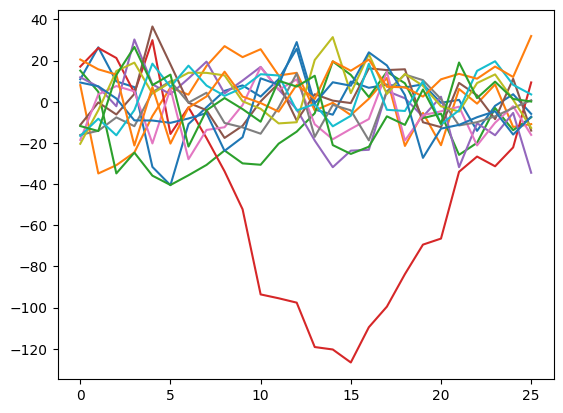

In [261]:
plt.plot(rec_window[arange_comp_elecs, idx-seq_n_before:idx+seq_n_after+1].T.cpu())
plt.show()

In [40]:
torch.cuda.empty_cache()
NUM_SEQS = 4

seq = ALL_SEQUENCES[4]
torch_window = torch.tensor(output_window, device="cuda")
arange = torch.arange(N_BEFORE+N_AFTER+1-2) # np.arange(1, output_window.size-1)
window_size = N_BEFORE + N_AFTER + 1

seqs_root_elecs = [seq.root_elec for i in range(NUM_SEQS)]
seqs_template_latencies = torch.vstack([seq.test_latencies+i for i in range(NUM_SEQS)])
seqs_latency_weights = torch.vstack([seq.test_latency_weights+i for i in range(NUM_SEQS)])

start_time = perf_counter()



window = torch_window[seq.root_elec]
main = window[1:-1]
greater_than_left = main > window[:-2]
greater_than_right = main > window[2:]
peaks = greater_than_left & greater_than_right
crosses = main >= strict_thresh_logit
peak_ind = torch.nonzero(peaks & crosses) + 1

elec_probs, latencies = torch.nn.functional.max_pool1d(torch_window, window_size, return_indices=True)
latencies = latencies.to(torch.float16).flatten()

for _ in range(10):
    for idx in peak_ind:
        # for seq in elec_to_seqs[root_elec]:
        #     if torch.sum(elec_probs[seq.inner_loose_elecs] >= loose_thresh_logit) < MIN_INNER_LOOSE_DETECTIONS:
        #         continue
            
        #     if torch.sum(elec_probs[seq.loose_elecs] >= loose_thresh_logit) < MIN_LOOSE_DETECTIONS_N:
        #         continue
            
            
        #     # latency_diff = latencies[seq.nor_comp_elecs] - seq.test_latencies
        #     latency_diff = torch.sum(latencies[seq.nor_comp_elecs] * seq.test_latency_elec_probs)
        # latency_diff = torch.abs((latencies[1:] - latencies[0]) - seqs_latencies)
        seqs_latencies = seqs_template_latencies + latencies[seqs_root_elecs][:, None]
        comp_latencies = latencies[seq.nor_comp_elecs]
        latency_diff = torch.abs(comp_latencies - seqs_latencies)
        latency_diff = torch.clip(latency_diff, max=CLIP_LATENCY_DIFF)
        latency_diff = torch.sum(latency_diff * seqs_latency_weights, axis=1)
        
    # elec_probs, latencies = torch.max(torch_window[seq.comp_elecs], axis=1)
    # if torch.sum(elec_probs[seq.test_inner_elecs] >= loose_thresh_logit) < 2:
    #     continue

torch.cuda.synchronize()
end_time = perf_counter()
print((end_time-start_time)*1000)
print(latency_diff)

# sigmoided = sigmoid(output_window)
# plt.plot(sigmoided)
# plt.scatter(peaks, sigmoided[peaks], color="orange")
# plt.show()

6.905371003085747
tensor([  2.9609,  52.6875, 106.0625, 161.2500], device='cuda:0',
       dtype=torch.float16)


In [ ]:
latencies[seqs_root_elecs][:, None]

tensor([[16.],
        [16.],
        [16.],
        [16.]], device='cuda:0', dtype=torch.float16)

In [ ]:
latencies.T

/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)
  """Entry point for launching an IPython kernel.


tensor([ 7.,  5.,  7., 16., 16., 10.,  1., 24., 29., 32., 23.,  6., 18., 32.,
         4., 32., 19.,  4.,  8., 24., 31., 21.,  6., 21., 26., 15., 17.,  0.,
         3.,  0.,  8., 32., 24., 22., 26., 28., 32.,  0., 28., 14., 18., 31.,
         0.,  0.,  5., 30., 25., 29., 25.,  1.,  0., 18., 28., 27., 28., 27.,
        29.,  6.,  7.,  7.,  9., 28., 26., 27., 29., 23., 17.,  0.,  9., 17.,
         3.,  0., 24., 21., 32., 32.,  3., 31., 28., 19.,  1., 21., 22.,  5.,
         8., 29., 11.,  5., 12., 23., 21., 32.,  2., 26.,  9., 32.,  7.,  7.,
        10.,  0., 25., 28.,  0., 11., 25.,  2., 24.,  7.,  9.,  5.,  0., 32.,
        12., 30., 29.,  3., 28., 28., 28.,  2., 15.,  0., 20.,  1.,  1., 29.,
        25., 19.,  6., 16., 23., 31.,  7.,  1., 24., 12., 21., 30., 20.,  2.,
        23., 13.,  5.,  3.,  4., 30., 31., 27., 26., 28., 28., 28., 19., 15.,
         7.,  8., 15., 22., 32., 19., 23.,  6.,  0., 29.,  1.,  0.,  7.,  1.,
         0., 32., 29.,  3., 19., 32., 21.,  0., 16.,  4., 28., 3